In [6]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma, sici
from scipy.integrate import trapz, simpson
import scipy.interpolate as scint
import pandas as pd
import os
# from sklearn.neighbors import KernelDensity
# from sklearn.ensemble import GradientBoostingClassifier as Gra_classifier
# from sklearn.ensemble import AdaBoostClassifier as Ada_classifier
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve, auc
import itertools
import time
from importlib import reload

plt.style.use("../KD_style.mplstyle")

In [1]:
def ullhfit(x, fitfunc, limits=None, fixed=None, **kwargs):
    # Written by Philip Kofoed-Djursner
    # Unbinned log likelihood fitter
    
    def obt(*args):
        # Obtimization function is taken from Troels Petersen
        # Empty results array
        logf = np.zeros_like(x)
        
        # compute the function value
        f = fitfunc(x, *args)
    
        # find where the PDF is 0 or negative (unphysical)        
        mask_f_positive = f > 0

        # calculate the log of f everyhere where f is positive
        logf[mask_f_positive] = np.log(f[mask_f_positive])
        # set everywhere else to badvalue (value should be so bad the fit is never accepted)
        logf[~mask_f_positive] = -1000000
        
        # compute the sum of the log values: the LLH
        llh = -np.sum(logf)
        return llh

    ullh_Min = Minuit(obt, **kwargs, name = [*kwargs]) # Setup; obtimization function, initial valuable guesses, names of variables. 
    ullh_Min.errordef = 0.5 # needed for likelihood fits. No explaination in the documentation.
    if limits:
        for i, limit in enumerate(limits):
            ullh_Min.limits[i] = limit
    if fixed:
        for i, fix in enumerate(fixed):
            ullh_Min.fixed[i] = fix
    ullh_Min.migrad() # Compute the fit
    valuesfit = np.array(ullh_Min.values, dtype = np.float64) # Convert to numpy
    errorsfit = np.array(ullh_Min.errors, dtype = np.float64) # Convert to numpy
    if not ullh_Min.valid: # Give custom error if the fit did not converge
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")
    # TO DO: 
    # *** Impliment p-value for ullh fit
    return valuesfit, errorsfit

def mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    # Compute accpet/reject Monte Carlo simulations 
    # Written by Philip Kofoed-Djursner
    
    # Initial random points in 2-dimensions
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    
    # Compute the assosiated y value with the x randomly generated
    yfunc = func(xran, **kwargs)
    
    # Compare random y with computed y. Random need to be less for equal to the computed for it to be accpeted
    bool_mask = yran <= yfunc
    
    # Calculated how many points are missing. Difference between requested and accepted
    missing = N_points - np.sum(bool_mask)
    
    if missing > 0: # If any points are missing request that amount through recursion. this will go on until N_accept = N_points
        xrest, yrest, bool_rest = mc_ac_new(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        # if missing = 0 return the arrays created. 
        return xran, yran, bool_mask
    # Merge points accpeted and points created through further along recursion
    finalx = np.append(xran, xrest)
    finaly = np.append(yran, yrest)
    finalbool = np.append(bool_mask, bool_rest)
    return finalx, finaly, finalbool

def mc_ac_new_for_p(func, xmin, xmax, ymin, ymax, N_points, *args):
    # Compute accpet/reject Monte Carlo simulations 
    # Written by Philip Kofoed-Djursner
    
    # Initial random points in 2-dimensions
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    
    # Compute the assosiated y value with the x randomly generated
    yfunc = func(xran, *args)
    
    # Compare random y with computed y. Random need to be less for equal to the computed for it to be accpeted
    bool_mask = yran <= yfunc
    
    # Calculated how many points are missing. Difference between requested and accepted
    missing = N_points - np.sum(bool_mask)
    
    if missing > 0: # If any points are missing request that amount through recursion. this will go on until N_accept = N_points
        xrest, yrest, bool_rest = mc_ac_new_for_p(func, xmin, xmax, ymin, ymax, missing, *args)
    else:
        # if missing = 0 return the arrays created. 
        return xran, yran, bool_mask
    # Merge points accpeted and points created through further along recursion
    finalx = np.append(xran, xrest)
    finaly = np.append(yran, yrest)
    finalbool = np.append(bool_mask, bool_rest)
    return finalx, finaly, finalbool

def mc_ac_df(func, xmin, xmax, ymin, ymax, N_points, upside_down = False, **kwargs):
    # Take Accept/Reject Monte Carlo functio and retrun in a nice format. 
    # Always contains N_points accepted points
    # Written by Philip Kofoed-Djursner
    
    # Get all x and y created and a boolean array to tell if it was accepted or rejected
    x, y, mask = mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    
    # If area of interest is above the cure and not below. Rare use cares for splines.
    if upside_down:
        mask = np.invert(mask)
        
    # Create DataFrame
    df = pd.DataFrame({"x": x, "y": y, "accept": mask})
    
    tries = len(x)
    eff = np.sum(mask)/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    
    # Returns DataFrame and dictionary of information of interest
    return df, {"area": area, "effeciency": eff, "tries": tries}

def raster_scan_2D(x, func, variables, ranges, points = [100, 100], vmax=None, **kwargs):
    # Written by Philip Kofoed-Djursner
    v1_range = np.linspace(*ranges[0], points[0])
    v2_range = np.linspace(*ranges[1], points[1])
    mesh = np.meshgrid(v1_range, v2_range)
    
    arguments = {**{key:value for key, value in zip(variables, mesh)}, **kwargs}
    
    llh = np.zeros((points[0], points[1]))
    for value in x:
        llh -= 2*np.log(func(value, **arguments))
    # llh = np.sum([np.log(func(value, **arguments)) for value in x], axis = 0)
    
    if vmax:
        ax = sns.heatmap(llh, cmap="Spectral", vmax=np.min(llh)+vmax)

    else:
        ax = sns.heatmap(llh, cmap="Spectral")
    ticks = 21
    ax.set_xticks(np.linspace(0, points[0], ticks))
    ax.set_xticklabels(np.around(np.linspace(*ranges[0], ticks),1))
    ax.set_yticks(np.linspace(0, points[1], ticks))
    ax.set_yticklabels(np.around(np.linspace(*ranges[1], ticks),1))
    
    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[1])
    ax.set_title('Raster Scan')
    plt.gca().invert_yaxis()

In [7]:
# Problem 1

data = pd.read_table("./Exam_Prob1.txt", sep = " ", names = ["1", "2", "3", "4", "5"])
display(data)
fig, axes = plt.subplots(1,5, figsize = (18,6))
for key, ax in zip(data.keys(), axes):
    ax.hist(data[key], bins = 100)
    

FileNotFoundError: [Errno 2] No such file or directory: './Exam_Prob1.txt'

In [2]:
xmin = 20
xmax = 27

def pdf2(x, a, b, c):
    return (np.sin(a*x) + c * np.exp(b*x) + 1)/((np.cos(a*xmin)-np.cos(a*xmax))/a + c*(np.exp(b*xmax) - np.exp(b*xmin))/b - xmin + xmax)

xlin = np.linspace(xmin, xmax, 1000)
# plt.plot(xlin, pdf2(xlin, 3/2*np.pi, -0.1, 30))
values, errors = ullhfit(data["1"].values, pdf2, a = 1.25*np.pi-1, b = -0.1, c = 6000)
plt.plot(xlin, pdf2(xlin, *values), color = "k")
print(values)
print(errors)
print(12.5/10*np.pi)
sns.histplot(data["1"], stat = "density", bins = 50)
plt.show()
values[0] = values[0]
def p_value_fit(data, func, values, runs):
    data_size = len(data)
    xmin = np.min(data)
    xmax = np.max(data)
    xlin = np.linspace(xmin, xmax, 10000)
    ymin = 0
    ymax = np.max(func(xlin, *values))
    llhs = np.zeros(runs)
    for run in range(runs):
        monte_x, _, mask = mc_ac_new_for_p(func, xmin, xmax, ymin, ymax, data_size, *values)
        accpeted_x = monte_x[mask]
        llh = np.sum(np.log(func(accpeted_x, *values)))
        llhs[run] = llh
    data_llh = np.sum(np.log(func(data, *values)))
    cumsum = np.cumsum([1 for i in range(runs)])/runs
    plt.plot(sorted(llhs),cumsum)
    plt.vlines(data_llh, 0, 1, color = "k")
    plt.show()
    monte_kde = stats.gaussian_kde(llhs)
    monte_mean = np.mean(llhs)
    if monte_mean > data_llh:
        p = monte_kde.integrate_box_1d(-np.inf, data_llh) + monte_kde.integrate_box_1d(monte_mean + np.abs(data_llh - monte_mean), np.inf)
    else:
        p = monte_kde.integrate_box_1d(-np.inf, monte_mean - np.abs(data_llh - monte_mean)) + monte_kde.integrate_box_1d(data_llh, np.inf)
    print(p)             
    sns.histplot(llhs, bins = 20, stat = "density")
    plt.vlines(data_llh, 0, 0.01, color = "k")
    plt.show()
    # sns.histplot(accpeted_x, bins = 50, color = "b")
    # plt.show()
    
p_value_fit(data["1"], pdf2, values, 1000)



        
    


NameError: name 'np' is not defined

[0.47241029 2.58028225]
[0.05203154 0.16082577]
3.9269908169872414


<AxesSubplot:xlabel='2', ylabel='Density'>

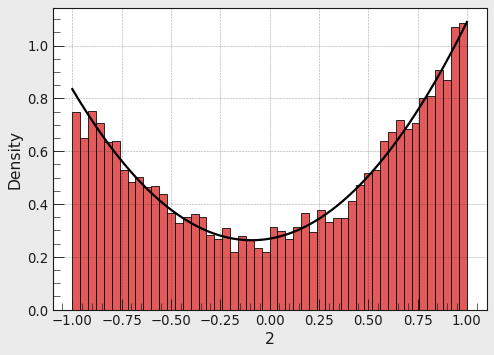

In [5]:
xmin = -1
xmax = 1

def pdf3(x, a, b):
    return (1+a*x+b*x**2)/(1/6*(xmax*(3*a*xmax+ 2*b*xmax**2 + 6) - 3*a*xmin**2 - 2*b*xmin**3 - 6 * xmin))

xlin = np.linspace(xmin, xmax, 1000)
# plt.plot(xlin, pdf3(xlin, 3/2*np.pi, -0.1))
values, errors = ullhfit(data["2"].values, pdf3, a = 1.2*np.pi, b = 1)
plt.plot(xlin, pdf3(xlin, *values), color = "k")
print(values)
print(errors)
print(12.5/10*np.pi)
sns.histplot(data["2"], stat = "density", bins = 50)



[9.18183607] [0.04235175]
[1.17193095e+03 7.83494265e-03] [8.51760165e+01 5.69450227e-04]


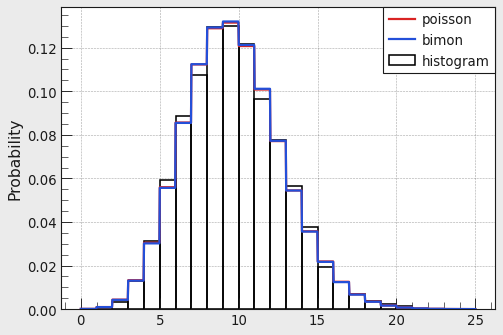

In [6]:
def pdf4(x, lamb):
    return stats.poisson.pmf(np.floor(x), lamb)

def pdf5(x, n, p):
    return stats.binom.pmf(np.floor(x), n, p)

values1, errors1 = ullhfit(data["3"].values, pdf4, lamb = 9.2)
values2, errors2 = ullhfit(data["3"].values, pdf5, n = 1500, p = 0.01)
print(values1, errors1)
print(values2, errors2)
xlin = np.linspace(0, 25, 1000)
plt.plot(xlin, pdf4(xlin, *values1), label = "poisson")
plt.plot(xlin, pdf5(xlin, *values2), label = "bimon")
sns.histplot(data["3"].values, stat = "probability", bins = 20, fill = False, color = "k", label = "histogram")
plt.legend()

[ 2.94845135 20.00360038] [0.12137834 0.09946428]


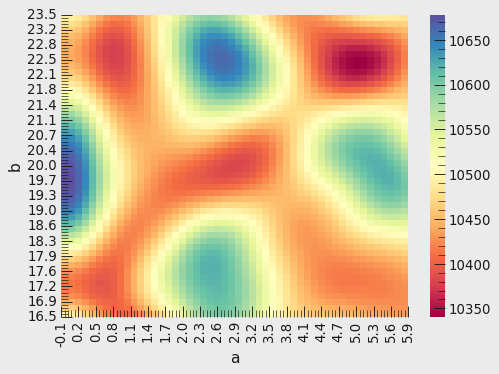

In [7]:
data3 = pd.read_table("./Exam_Prob3.txt", names = ["1"])
# sns.histplot(data3["1"].values, bins = 50, stat = "density")

def pro3_pdf(x, a, b):
    return (np.cos(a*x)*np.cos(b*x)/x**2 + 2) / (0.5*((b-a)*sici((a-b)*3)[0] - (b+a)*sici((a+b)*3)[0] - (2*np.cos(a*3)*np.cos(b*3)/3) + 4*3) - 0.5*((b-a)*sici((a-b)*1)[0] - (b+a)*sici((a+b)*1)[0] - (2*np.cos(a*1)*np.cos(b*1)/1) + 4*1))

xlin = np.linspace(1, 3, 1000)

values, errors = ullhfit(data3["1"].values, pro3_pdf, limits = [(0,15), (9, 27)], a = 5, b = 20)
print(values, errors)
# plt.plot(xlin, pro3_pdf(xlin, *values))

raster_scan(data3["1"], pro3_pdf, ["a", "b"], [(values[0]-3, values[0]+3), (values[1]-3.5, values[1]+3.5)], points = [50, 50])

<AxesSubplot:xlabel='azimuth', ylabel='zenith'>

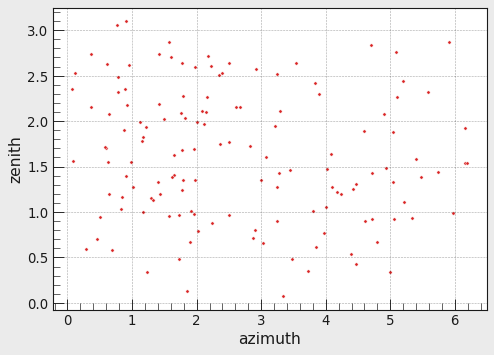

In [8]:
data2 = pd.read_table("./Exam_Problem2.txt", sep = " ", names = ["azimuth", "zenith"], skiprows=2)
# ax = plt.subplot(111, projection = "mollweide")
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data = data2, x = "azimuth", y = "zenith", ax = ax)


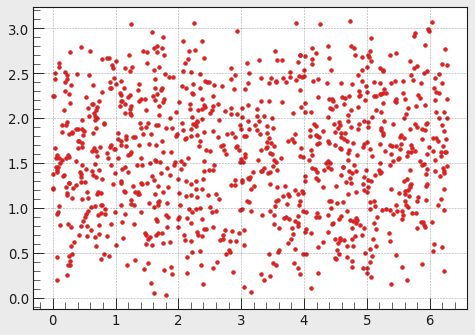

In [9]:
points = 1000

azimuth = np.random.uniform(0, 2*np.pi, points)
cos_zenith = np.random.uniform(-1, 1, points)
zenith = np.arccos(cos_zenith)
plt.scatter(azimuth, zenith)

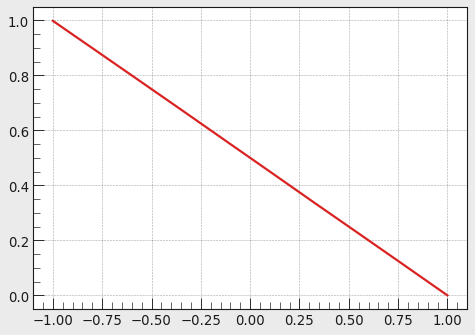

In [10]:
def auto_corr(azimuth, zenith, cos_phi):
    N_tot = len(azimuth)
    auto_sum = 0
    for i in range(N_tot):
        for j in range(i-1):
                v1 = [np.sin(zenith[i]) * np.cos(azimuth[i]), np.sin(zenith[i])*np.sin(azimuth[i]), np.cos(zenith[i])]
                v2 = [np.sin(zenith[j]) * np.cos(azimuth[j]), np.sin(zenith[j])*np.sin(azimuth[j]), np.cos(zenith[j])]
                auto_sum += np.heaviside(np.dot(v1, v2) - cos_phi, 1)
    auto_sum /= N_tot*(N_tot-1)/2
    return auto_sum

reso = 10
result = np.zeros(reso)

points = 1000

azimuth = np.random.uniform(0, 2*np.pi, points)
cos_zenith = np.random.uniform(-1, 1, points)
zenith = np.arccos(cos_zenith)

for idx, cos_phi in enumerate(np.linspace(-1,1, reso)):
    result[idx] = auto_corr(azimuth, zenith, cos_phi)

plt.plot(np.linspace(-1,1, reso), result)
    
    

In [13]:
def autocorrelate_opt(azi, zen, splits):
    auto_points = []
    N_tot = len(azi)
    norm = 2/(N_tot*(N_tot-1)) 
    X_i = np.sin(zen)*np.cos(azi)
    Y_i = np.sin(zen)*np.sin(azi)
    Z_i = np.cos(zen)
    for phi in np.linspace(1,-1,splits):
        i_sum = 0
        for i in range(len(azi)):
            x_i, y_i, z_i = X_i[i], Y_i[i], Z_i[i]
            X_j = np.sin(zen[:i-1])*np.cos(azi[:i-1])
            Y_j = np.sin(zen[:i-1])*np.sin(azi[:i-1])
            Z_j = np.cos(zen[:i-1])
            D_angle = X_j*x_i + Y_j*y_i + Z_j*z_i
            C_j = np.sum(np.heaviside(D_angle - phi, 1))
            i_sum += C_j
        C_tot = norm*i_sum
        auto_points.append(C_tot)
    return auto_points
# N_points = 2000
# splits = 10
# azi = np.random.uniform(0, 2*np.pi, N_points)
# zen = np.arccos(np.random.uniform(-1, 1, N_points))
# standard_C = autocorrelate_opt(azi, zen, splits)
# print("done standard")
# N_points = 10
# runs = 10
# ks_array = np.zeros(runs)
# for i in range(runs):
#     azi = np.random.uniform(0, 2*np.pi, N_points)
#     zen = np.arccos(np.random.uniform(-1, 1, N_points))
#     C = autocorrelate_opt(azi, zen, splits)
#     ks_stat = stats.ks_2samp(C, standard_C)
#     ks_array[i] = ks_stat[0]
    # print(ks_stat)

# sns.histplot(ks_array, bins = 100)

    

In [14]:
def autocorrelate_opt_new(azi, zen, splits):
    N_tot = len(azi)
    norm = 1/(N_tot*(N_tot-1)) 
    az, ze = np.meshgrid(azi, zen)
    X_i = np.sin(ze)*np.cos(az)
    Y_i = np.sin(ze)*np.sin(az)
    Z_i = np.cos(ze)
    X_j = np.sin(ze.T)*np.cos(az.T)
    Y_j = np.sin(ze.T)*np.sin(az.T)
    Z_j = np.cos(ze.T)
    
    cos_phi = X_i*X_j + Y_i*Y_j + Z_i*Z_j
    auto_points = []
    for cos_phi_test in np.linspace(-1, 1, splits):
        C_matrix = np.heaviside(cos_phi - cos_phi_test, 1)
        auto_points.append((np.sum(C_matrix) - np.trace(C_matrix))*norm)
    return np.array(auto_points)

In [38]:
N_points = 2000
splits = 100
azi = np.random.uniform(0, 2*np.pi, N_points)
zen = np.arccos(np.random.uniform(-1, 1, N_points))
standard_C = autocorrelate_opt_new(azi, zen, splits)
print("done standard")
N_points = 139
runs = 5000
ks_array = np.zeros(runs)
for i in range(runs):
    azi = np.random.uniform(0, 2*np.pi, N_points)
    zen = np.arccos(np.random.uniform(-1, 1, N_points))
    C = autocorrelate_opt_new(azi, zen, splits)
    ks_array[i] = np.max(np.abs(standard_C - C))

done standard


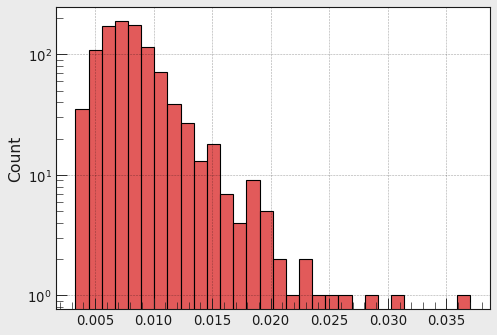

In [16]:
ax = sns.histplot(ks_array, bins = 30)
ax.set_yscale("log")

In [39]:
kde = stats.gaussian_kde(ks_array, bw_method= np.std(ks_array)/0.01)
C_true = autocorrelate_opt_new(data2["azimuth"], data2["zenith"], 100)
KS_true = np.max(np.abs(standard_C - C_true))
print(KS_true)
p = 1 - kde.integrate_box_1d(0, KS_true)
print(p)

0.022417134435218866
0.004894605702218668


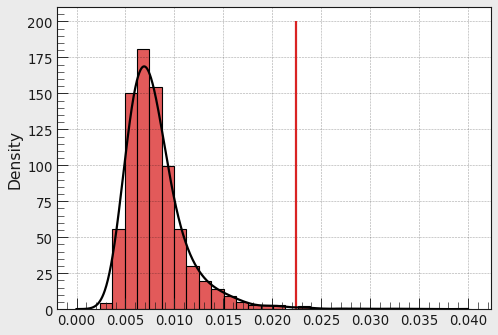

In [40]:
xlin = np.linspace(0, 0.04, 1000)
ax = sns.histplot(ks_array, bins = 30, stat = "density")
plt.plot(xlin, kde(xlin), color = "k")
plt.vlines(KS_true, 0 , 200)

In [22]:
N_points = 2000
splits = 100
azi = np.random.uniform(0, 2*np.pi, N_points)
zen = np.arccos(np.random.uniform(-1, 1, N_points))
standard_C = autocorrelate_opt_new(azi, zen, splits)
print("done standard")
N_points = 139
iso_points = int(N_points*0.8)
runs = 1000
ks_array_HA = np.zeros(runs)
for i in range(runs):
    azi_iso = np.random.uniform(0, 2*np.pi, iso_points)
    azi_uni = np.random.uniform(0.225*np.pi, 0.725*np.pi, N_points-iso_points)   
    azi = np.append(azi_iso, azi_uni)
    zen_iso = np.arccos(np.random.uniform(-1, 1, iso_points))
    zen_uni = np.random.uniform(0.3*np.pi, np.pi, N_points-iso_points)
    zen = np.append(zen_iso, zen_uni)
    C = autocorrelate_opt_new(azi, zen, splits)
    ks_array_HA[i] = np.max(np.abs(standard_C - C))

done standard


0.3909917626416497


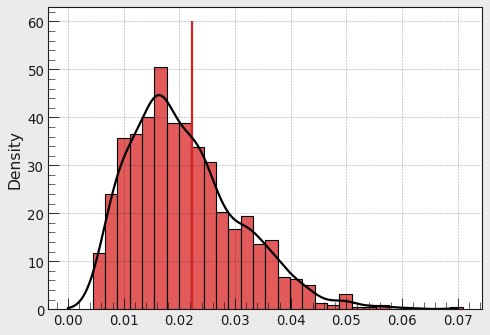

In [31]:
kde_HA  = stats.gaussian_kde(ks_array_HA, bw_method = 100*(np.max(ks_array_HA) - np.min(ks_array_HA))/30)
p_HA = 1 - kde_HA.integrate_box_1d(0, KS_true)
print(p_HA)
xlin = np.linspace(0, 0.07, 1000)
ax = sns.histplot(ks_array_HA, bins = 30, stat = "density")
plt.plot(xlin, kde_HA(xlin), color = "k")
plt.vlines(KS_true, 0 , 60)
plt.show()
# p = 1 - kde_HA.integrate_box_1d(0, KS_true)
# print(p)

In [36]:
N_points = 2000
splits = 100
azi = np.random.uniform(0, 2*np.pi, N_points)
zen = np.arccos(np.random.uniform(-1, 1, N_points))
standard_C = autocorrelate_opt_new(azi, zen, splits)
print("done standard")
N_points = 139
iso_points = int(N_points*0.85)
runs = 1000
ks_array_HB = np.zeros(runs)
for i in range(runs):
    azi_iso = np.random.uniform(0, 2*np.pi, iso_points)
    azi_uni = np.random.uniform(0, np.pi, N_points-iso_points)   
    azi = np.append(azi_iso, azi_uni)
    zen_iso = np.arccos(np.random.uniform(-1, 1, iso_points))
    zen_uni = np.random.uniform(0.5*np.pi, np.pi, N_points-iso_points)
    zen = np.append(zen_iso, zen_uni)
    C = autocorrelate_opt_new(azi, zen, splits)
    ks_array_HB[i] = np.max(np.abs(standard_C - C))

done standard


0.16298541174753767


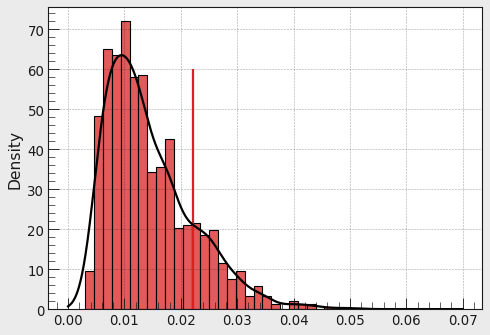

In [37]:
kde_HB  = stats.gaussian_kde(ks_array_HB)
p_HB = 1 - kde_HB.integrate_box_1d(0, KS_true)
print(p_HB)
xlin = np.linspace(0, 0.07, 1000)
ax = sns.histplot(ks_array_HB, bins = 30, stat = "density")
plt.plot(xlin, kde_HB(xlin), color = "k")
plt.vlines(KS_true, 0 , 60)
plt.show()
# p = 1 - kde_HA.integrate_box_1d(0, KS_true)
# print(p)